In [120]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
plt.style.use('seaborn')

In [121]:
data_folder = 'data/'
data = pd.read_csv(data_folder + 'en.openfoodfacts.org.products.csv', sep='\t')

/home/painguin/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (0,3,5,24,25,26,28,36,41,49) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Data Preprocessing

### Chosen Fields

(at least some text that explains why we dropped the other fields)

In [126]:
chosen_fields = ['product_name', 'packaging_tags', 'brands_tags',
                 'origins_tags', 'manufacturing_places_tags', 'labels_en', 'stores', 'countries_en',
                 'additives_n', 'ingredients_from_palm_oil_n', 'ingredients_that_may_be_from_palm_oil_n', 
                 'nutrition_grade_fr', 'pnns_groups_1', 'fruits-vegetables-nuts_100g',
                 'main_category_en', 'energy_100g', 'energy-from-fat_100g', 'fat_100g', 
                 'saturated-fat_100g', 'monounsaturated-fat_100g', 'polyunsaturated-fat_100g', 
                 'omega-3-fat_100g', 'omega-6-fat_100g', 'omega-9-fat_100g', 'trans-fat_100g', 
                 'cholesterol_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'sodium_100g', 
                 'nutrition-score-fr_100g', 'nutrition-score-uk_100g', 'carbon-footprint_100g', 'first_packaging_code_geo']

data = data[chosen_fields]

## Field Cleaning

The 'pnns_groups_1' field is particularly usefull in our study. 
Indeed, it sorts the different food entries by some clear category, as seen below.

A simple map allows for better organisation and also cleans the duplicate field entries:

In [127]:
my_map = {'unknown' : 'Unknown',
 'Sugary snacks' : 'Snacks', 
 'Milk and dairy products' : 'Fish Meat Eggs Dairy',
 'Composite foods' : 'Composite', 
 'Cereals and potatoes' : 'Starchy', 
 'Fish Meat Eggs' : 'Fish Meat Eggs Dairy',
 'Beverages' : 'Beverages',
 'Fat and sauces' : 'Fat Sauces',
 'Fruits and vegetables' : 'Fruits Vegetables',
 'Salty snacks' : 'Snacks',
 'fruits-and-vegetables' : 'Fruits Vegetables',
 'sugary-snacks' : 'Snacks',
 'cereals-and-potatoes' : 'Starchy',
 'salty-snacks' : 'Snacks'
}

data['Category'] = data['pnns_groups_1'].replace(my_map)

/home/painguin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Now the categories are clear:

In [128]:
data['Category'].value_counts()

Unknown                 122881
Snacks                   37054
Fish Meat Eggs Dairy     31941
Composite                14670
Starchy                  14612
Fruits Vegetables        12632
Beverages                12411
Fat Sauces               11427
Name: Category, dtype: int64

From the 'main_category_en' field, we can recover more entries for the previous categories, as well as a new meaningfull category 'Plant-based foods and beverages', that we will rename 'Veggie' and add it as a new binary field in the data set.

In [129]:
data['main_category_en'].value_counts().head(20)

Plant-based foods and beverages    38524
Beverages                          26110
Sugary snacks                      25209
Dairies                            16145
Meats                               9801
Groceries                           9703
Meals                               8349
Spreads                             4629
Frozen foods                        3154
Fruit juices                        3108
Desserts                            3080
Salty snacks                        3008
Seafood                             2921
Canned foods                        2770
Fats                                1878
Baby foods                          1037
Sweeteners                           945
Sandwiches                           905
Farming products                     798
Fish and meat and eggs               741
Name: main_category_en, dtype: int64

First the usefull categories of `pnns_groups_1` and `main_category_en` are merged.
This merged categorical field is called `category`.

In [130]:
my_map_2 = {
    'Beverages' : 'Beverages',
    'Sugary snacks' : 'Snacks',
    'Dairies' : 'Fish Meat Eggs Dairy',
    'Meats' : 'Fish Meat Eggs Dairy',
    'Meals' : 'Composite',
    'Fruit juices' : 'Beverages',
    'Salty snacks' : 'Snacks',
    'Fats' : 'Fat Sauces',
    'Fish and meat and eggs' : 'Fish Meat Eggs Dairy'
}

In [131]:
not_in_category = data[data['Category'].isna()]
keys = my_map_2.keys()
not_in_category.query('main_category_en in @keys')['main_category_en'].value_counts()

Beverages                 5844
Meats                       68
Meals                       16
Fish and meat and eggs      12
Name: main_category_en, dtype: int64

We see that the number of usefull entries that are not already present in `pnns_group_1` are mainly from the `Beverages` category. Nonetheless, we build the new `Category` field as previously exposed, and add these categories, as well as the `pnns_group_1` fields.

In [132]:
# Adds the values in 'main_category_en' that are not in 'pnns_groups_1' after applying the map
new_vals = not_in_category.query('main_category_en in @keys')['main_category_en'].replace(my_map_2)
data.loc[new_vals.index, 'Category'] = new_vals

/home/painguin/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Here is the new 'Category' field.

In [133]:
data['Category'].value_counts()

Unknown                 122881
Snacks                   37054
Fish Meat Eggs Dairy     32021
Beverages                18255
Composite                14686
Starchy                  14612
Fruits Vegetables        12632
Fat Sauces               11427
Name: Category, dtype: int64

Now the `Plant based food and beverages category` is used to create a new field called `Veggie`.

In [134]:
data['Veggie'] = data['main_category_en'] == 'Plant-based foods and beverages'

/home/painguin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


The veggie fields from `Category` are also added:

In [135]:
data['Veggie'] = np.logical_or(data['Veggie'], data['Category'] == 'Fruits Vegetables')
data['Veggie'] = np.logical_or(data['Veggie'], data['Category'] == 'Starchy')

/home/painguin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/painguin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [136]:
data['Veggie'].value_counts()

False    658551
True      39926
Name: Veggie, dtype: int64

Notice that the `False` value doesn't mean that an entry is not veggie.

# Nutri-Score

The Nutri-Score system was developped after Article 14 of the Modernisation Law for the health system, dated 26 January 2016, required the french authorities to recommend a front-of-pack system of labelling that would be simple and accessible for all. 
The new system includes a colour coded scheme, ranging from green to orange, associated with letters from A to E. Productes designated with an 'A' have the best nutritional quality, while products designated with an E have poorer nutritional quality.

## Points A

| Points | Energy (kJ) | Fat (g) | Sugar (g) | Sodium (mg) |
|:------:|:-----------:|:-------:|:---------:|:-----------:|
|    0   |    <=335    |   <=1   |   <=4.5   |     <=90    |
|    1   |     >335    |    >1   |    >4.5   |     >90     |
|    2   |     >670    |    >2   |     >9    |     >180    |
|    3   |    >1005    |    >3   |   >13.5   |     >270    |
|    4   |    >1340    |    >4   |    >18    |     >360    |
|    5   |    >1675    |    >5   |   >22.5   |     >450    |
|    6   |    >2010    |    >6   |    >27    |     >540    |
|    7   |    >2345    |    >7   |    >31    |     >630    |
|    8   |    >2680    |    >8   |    >36    |     >720    |
|    9   |    >3015    |    >9   |    >40    |     >810    |
|   10   |    >3350    |   >10   |    >45    |     >900    |

## Points C

| Points | Fruits Vegetables Nuts (%) | Fiber (g) | Proteins (g) |
|:------:|:--------------------------:|:---------:|:------------:|
|    0   |            <=40            |   <=0.9   |     <=1.6    |
|    1   |             >40            |    >0.9   |     >1.6     |
|    2   |             >60            |    >1.9   |     >3.2     |
|    3   |              -             |    >2.8   |     >4.8     |
|    4   |              -             |    >3.7   |     >6.4     |
|    5   |             >80            |    >4.7   |     >8.0     |

## Nutri-Score Computation
  * If `points A` < 11, then `score` = `points A` - `points C`
  * If `points A` >= 11:
      * If `points(Fruits/Vegetables/Nuts)` = 5, then `score` = `points(A)` - `points(C)`
      * If `points(Fruits/Vegetables/Nuts)` < 5, then `score` = `points(A)` - (`points(Fiber)` + `points(Fruits/Vegetables/Nuts)`)

## Letters Thresholds
### Solid Food
  * A: until -1
  * B: from 0 to 2
  * C: from 3 to 10
  * D: from 11 to 18
  * E: 19 and more
  
### Beverages 
  * A: mineral and spring water
  * B: until 1
  * C: from 2 to 5
  * D: from 6 to 9
  * E: 10 and more

## Warning
When fiber content is not present, its eventual positive contribution is not taken into account.

Percentages corresponding to Fruits/Vegetables/Nuts are mainly missing from the packaging. 
It will be derived from other products as follows:
  * 100% : Fruit Juices
  * 90% : Fruit Compote
  * 85% : Vegetables
  * 50% : Jams
  
Tubers are not considered as vegetables for the nutri-score.

In [140]:
data[(data['main_category_en'] == 'Fruit juices')]['fruits-vegetables-nuts_100g'].fillna(100, inplace=True)

/home/painguin/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5430: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [141]:
beverages = data[data['Category'] == 'Beverages']

In [142]:
energy_bins = [data['energy_100g'].min(), 335, 670, 1005, 1340, 1675, 2010, 2345, 2680, 3015, 3350, data['energy_100g'].max()]
data['energy_points'] = pd.cut(data['energy_100g'], energy_bins, labels=range(11)).astype(float)

bev_energy_bins = [beverages['energy_100g'].min() - 1, 0, 30, 60, 90, 120, 150, 180, 210, 240, 270, beverages['energy_100g'].max()]
bev_energy_points = pd.cut(beverages['energy_100g'], bev_energy_bins, labels=range(11), include_lowest=True)
data['energy_points'][bev_energy_points.index] = bev_energy_points

fat_bins = [data['fat_100g'].min(), 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, data['fat_100g'].max()]
data['fat_points'] = pd.cut(data['fat_100g'], fat_bins, labels=range(11)).astype(float)

sugar_bins = [data['sugars_100g'].min(), 4.5, 9, 13.5, 18, 22.5, 27, 31, 36, 40, 45, data['sugars_100g'].max()]
data['sugar_points'] = pd.cut(data['sugars_100g'], sugar_bins, labels=range(11)).astype(float)

bev_sugar_bins = [beverages['sugars_100g'].min() - 1, 0, 1.5, 3, 4.5, 6, 7.5, 9, 10.5, 12, 13.5, beverages['sugars_100g'].max()]
bev_sugar_points = pd.cut(beverages['sugars_100g'], bev_sugar_bins, labels=range(11))
data['sugar_points'][bev_sugar_points.index] = bev_sugar_points

sodium_bins = [data['sodium_100g'].min(), 90, 180, 270, 360, 450, 540, 630, 720, 810, 900, data['sodium_100g'].max()]
data['sodium_points'] = pd.cut(data['sodium_100g'], sodium_bins, labels=range(11)).astype(float)

data['points_A'] = data['energy_points'] + data['fat_points'] + data['sugar_points'] + data['sodium_points']

/home/painguin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/painguin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [143]:
fvn_bins = [data['fruits-vegetables-nuts_100g'].min(), 40, 60, 80, data['fruits-vegetables-nuts_100g'].max()]
data['fvn_points'] = pd.cut(data['fruits-vegetables-nuts_100g'], fvn_bins, labels=[0,1,2,5]).astype(float)

bev_fvn_bins = [beverages['fruits-vegetables-nuts_100g'].min() - 1, 40, 60, 80, beverages['fruits-vegetables-nuts_100g'].max()]
bev_fvn_points = pd.cut(beverages['fruits-vegetables-nuts_100g'], bev_fvn_bins, labels=[0,2,4,10])
data['fvn_points'][bev_fvn_points.index] = bev_fvn_points

fiber_bins = [data['fiber_100g'].min(), 0.9, 1.9, 2.8, 3.7, 4.7, data['fiber_100g'].max()]
data['fiber_points'] = pd.cut(data['fiber_100g'], fiber_bins, labels=range(6)).astype(float)
data['fiber_points'].fillna(0, inplace=True)

proteins_bins = [data['proteins_100g'].min(), 1.6, 3.2, 4.8, 6.4, 8.0, data['proteins_100g'].max()]
data['proteins_points'] = pd.cut(data['proteins_100g'], proteins_bins, labels=range(6)).astype(float)

data['points_C'] = data['fvn_points'] + data['fiber_points'] + data['proteins_points']

/home/painguin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [144]:
def compute_score(row):
    A = row['points_A']
    C = row['points_C']
    fvn = row['fvn_points']
    fiber = row['fiber_points']
    if A < 11 or fvn == 5:
        return A - C
    else:
        return A - (fiber + fvn)

In [145]:
data['score'] = data.apply(compute_score, axis=1)

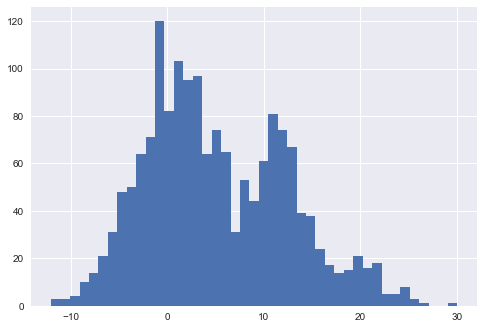

In [146]:
data['score'].hist(bins=int(data['score'].max() - data['score'].min() + 1))

In [159]:
def score_letter(row):
    score = row['score']
    product_name = row['product_name']
    
    if score != score:
        return np.nan
    
    if row['Category'] == 'Beverages':
        if product_name == product_name and 'mineral' in row['product_name']:
            return 'A'
        elif score <= 1:
            return 'B'
        elif score <= 5:
            return 'C'
        elif score <= 9:
            return 'D'
        else:
            return 'E'
    else:
        if score <= -1:
            return 'A'
        elif score <= 2:
            return 'B'
        elif score <= 10:
            return 'C'
        elif score <= 18:
            return 'D'
        else:
            return 'E'

In [160]:
data['score_letter'] = data.apply(score_letter, axis=1)

In [445]:
score_mean_by_category = data[['Category', 'score']].groupby('Category').mean()
score_mean_by_category

,score
Category,
Beverages,11.373016
Composite,1.170667
Fat Sauces,1.428571
Fish Meat Eggs Dairy,4.225806
Fruits Vegetables,-1.141566
Snacks,12.703180
Starchy,6.860465
Unknown,4.656805


In [474]:
letter_counts_per_cat = data.groupby(['Category', 'score_letter']).count()[['score']].drop('Unknown')
letter_counts_per_cat

score
Category             score_letter       
Beverages            B                 4
                     C                42
                     D                29
                     E               177
Composite            A               143
                     B               107
                     C               104
                     D                21
Fat Sauces           A                 5
                     B                 4
                     C                 3
                     D                 2
Fish Meat Eggs Dairy A                24
                     B                29
                     C               114
                     D                18
                     E                 1
Fruits Vegetables    A               201
                     B                89
                     C                29
                     D                13
Snacks               A                 2
                     B                 5
                     C               101
                     D               110
                     E                65
Starchy              A                 6
                     B                 5
                     C                18
                     D                13
                     E                 1

In [475]:
letter_counts_per_cat.loc[('Beverages', 'A'), :] = 0
letter_counts_per_cat.loc[('Composite', 'E'), :] = 0
letter_counts_per_cat.loc[('Fat Sauces', 'E'), :] = 0
letter_counts_per_cat.loc[('Fruits Vegetables', 'E'), :] = 0

letter_counts_per_cat.sort_index(inplace=True)

In [480]:
nutri_score_colors = ['green', 'limegreen', 'gold', 'darkorange', 'orangered']

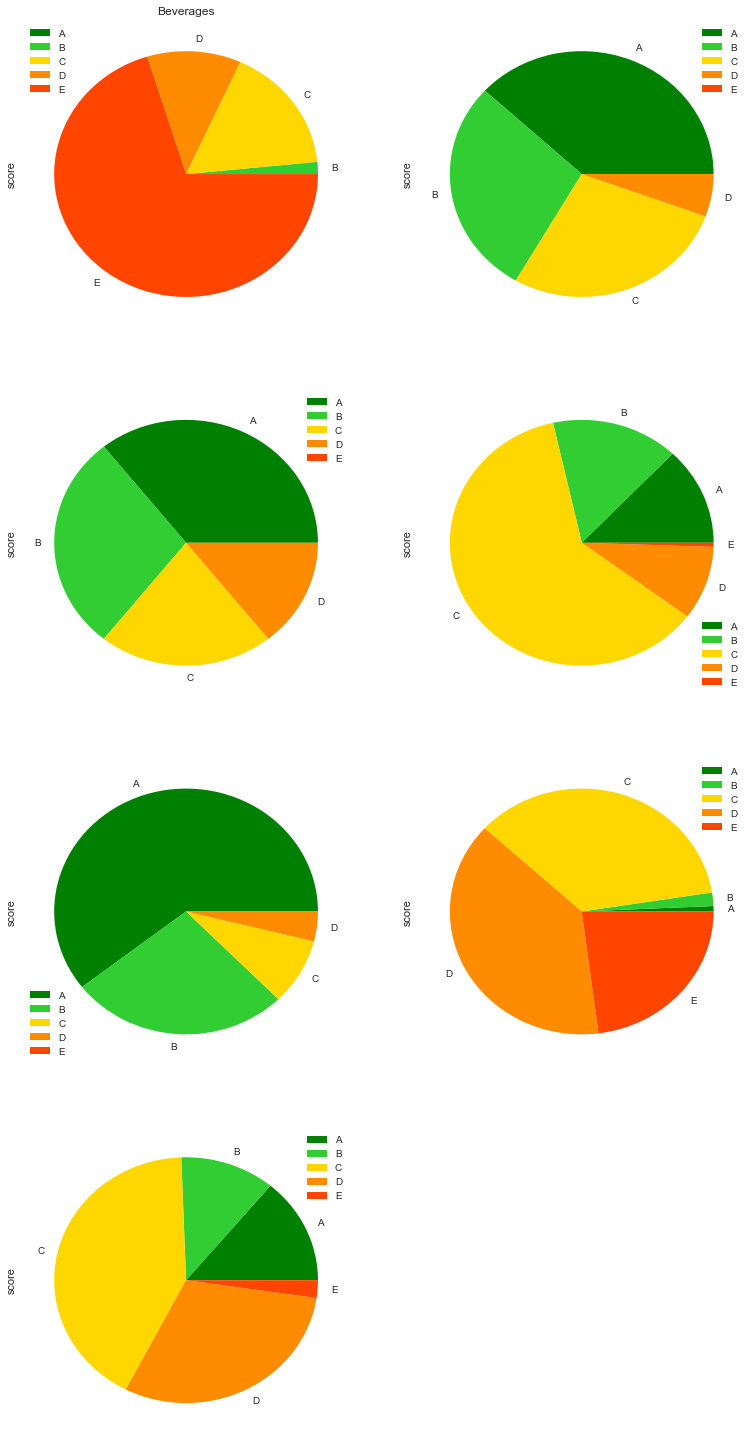

In [487]:
plt.figure(figsize=(13, 26))
letter_counts_per_cat.loc['Beverages'].plot.pie('score', ax=plt.subplot(421), title='Beverages', colors=nutri_score_colors)
letter_counts_per_cat.loc['Composite'].plot.pie('score', ax=plt.subplot(422), colors=nutri_score_colors)
letter_counts_per_cat.loc['Fat Sauces'].plot.pie('score', ax=plt.subplot(423), colors=nutri_score_colors)
letter_counts_per_cat.loc['Fish Meat Eggs Dairy'].plot.pie('score', ax=plt.subplot(424), colors=nutri_score_colors)
letter_counts_per_cat.loc['Fruits Vegetables'].plot.pie('score', ax=plt.subplot(425), colors=nutri_score_colors)
letter_counts_per_cat.loc['Snacks'].plot.pie('score', ax=plt.subplot(426), colors=nutri_score_colors)
letter_counts_per_cat.loc['Starchy'].plot.pie('score', ax=plt.subplot(427), colors=nutri_score_colors)

In [309]:
totals = letter_counts_per_cat.reset_index()[['Category', 'score']].groupby('Category').sum()
score_distr_per_cat = letter_counts_per_cat / totals

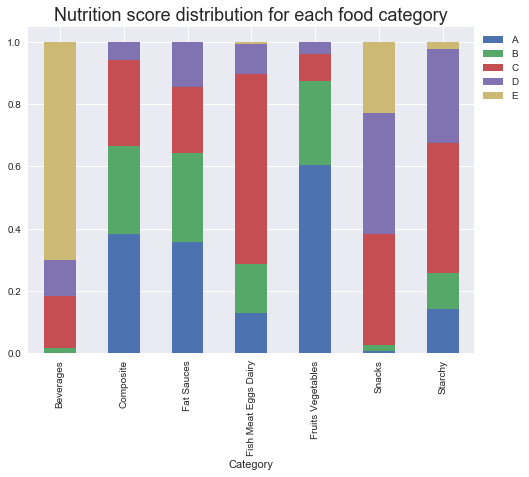

In [365]:
score_distr_per_cat.reset_index().pivot(index='Category', columns='score_letter', values='score').plot.bar(stacked=True, figsize=(8,6))
plt.legend(bbox_to_anchor=(1, 1.0))
plt.title('Nutrition score distribution for each food category', fontsize=18);

In [366]:
score_distr_per_cat

score
Category             score_letter          
Beverages            B             0.015873
                     C             0.166667
                     D             0.115079
                     E             0.702381
Composite            A             0.381333
                     B             0.285333
                     C             0.277333
                     D             0.056000
Fat Sauces           A             0.357143
                     B             0.285714
                     C             0.214286
                     D             0.142857
Fish Meat Eggs Dairy A             0.129032
                     B             0.155914
                     C             0.612903
                     D             0.096774
                     E             0.005376
Fruits Vegetables    A             0.605422
                     B             0.268072
                     C             0.087349
                     D             0.039157
Snacks               A             0.007067
                     B             0.017668
                     C             0.356890
                     D             0.388693
                     E             0.229682
Starchy              A             0.139535
                     B             0.116279
                     C             0.418605
                     D             0.302326
                     E             0.023256

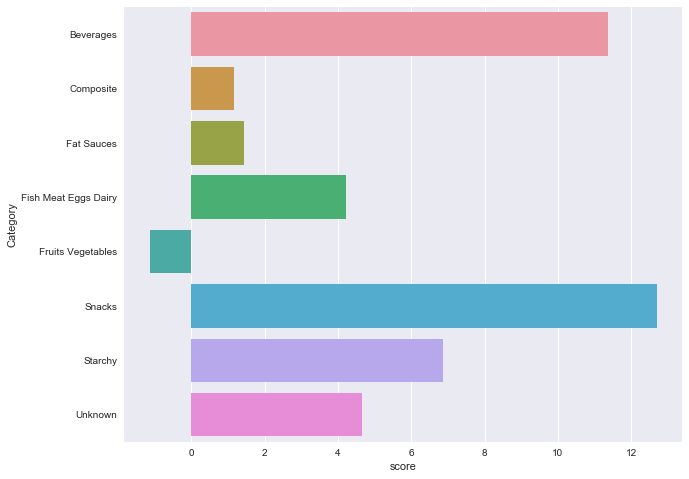

In [164]:
plt.figure(figsize=(10,8))
sns.barplot(score_mean_by_category.score, score_mean_by_category.index,orient='h')

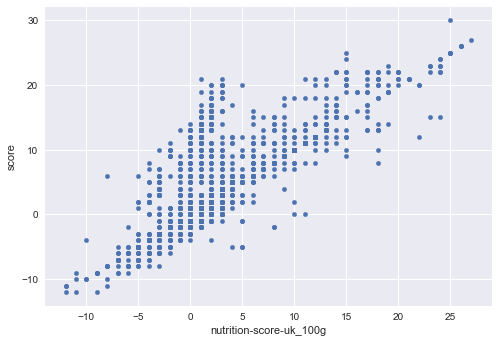

In [165]:
data.plot.scatter('nutrition-score-uk_100g', 'score')

In [27]:
data[data['carbon-footprint_100g'].notna()]

,product_name,packaging_tags,brands_tags,origins_tags,manufacturing_places_tags,labels_en,stores,countries_en,additives_n,ingredients_from_palm_oil_n,...,energy_points,fat_points,sugar_points,sodium_points,points_A,fvn_points,fiber_points,proteins_points,points_C,score
146124,Green tea,NaN,arizona,NaN,NaN,Carbon footprint,NaN,France,NaN,NaN,...,0,NaN,1,NaN,NaN,0.0,0.0,0.0,0.0,NaN
185408,châtaignes pelées et rôties cesares,conserve,cesares,chine,chine,Carbon footprint,sami fruits,Canada,0.0,0.0,...,2,0.0,2,NaN,NaN,0.0,2.0,2.0,4.0,NaN
212207,NaN,NaN,NaN,NaN,NaN,Carbon footprint,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN
213348,KLAST RED BERRY CHEWING GUM,12-sticks,NaN,batook-chewing-gum,batook-chewing-gum-saudi-arabia,"Carbon footprint,Carbon footprint",KEEP IN DRY AND COLD PLACE,World,11.0,0.0,...,2,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0,NaN
213618,NaN,box,kinder,usa,NaN,"Bio,Empreinte-carbone,Carbon footprint",jd,China,NaN,NaN,...,0,10.0,2,0.0,12,0.0,5.0,5.0,10.0,7.0
213804,NaN,"150ml,500ml,625ml,1-86l",mandy-hills,"sugar,salt",australia,"Halal,Carbon footprint","Australia,New Zealand",Australia,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN
214174,Nestle Aguitas Manzana,botella-de-plastico,nestle,cd-de-mexico,cd-de-mexico,"es:ecoce,Carbon footprint","walmart,bodega aurrera,sams club",Mexico,3.0,0.0,...,0,NaN,0,0.0,NaN,0.0,0.0,0.0,0.0,NaN
214219,Terrine de Chevreuil,"conserve,bocal,verre,180gr","ajm,sarl-ajm","france,saveur-occitanie","bagard,gard,occitanie,france,30140","Carbon footprint,fr:fait-maison,Carbon footprint","SARL AJM,AJM",France,0.0,0.0,...,4,10.0,0,0.0,14,0.0,0.0,5.0,5.0,14.0
214227,TERRINE AUX CHÂTAIGNES,"conserve,bocal,verre,verrine,180gr","ajm,sarl-ajm","france,saveur-occitanie","france,occitanie,gard,bagard,30,30140","fr:fait-maison,Carbon footprint","AJM,Sarl AJM",France,0.0,0.0,...,4,10.0,0,0.0,14,0.0,0.0,5.0,5.0,14.0
214309,NaN,NaN,NaN,poland,NaN,"Carbon footprint,pl:looking-for-bugs,Carbon fo...",NaN,Poland,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN


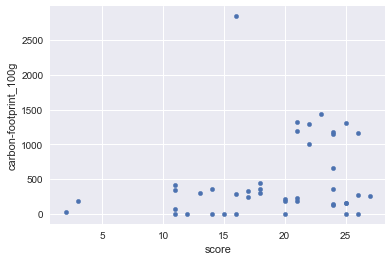

In [28]:
data[data['Category'] == 'Snacks'].plot.scatter('score', 'carbon-footprint_100g')

In [29]:
carbon_mean_by_category = data[['Category', 'carbon-footprint_100g']].groupby('Category').mean() / 20

In [30]:
pd.concat((carbon_mean_by_category, score_mean_by_category), axis=1).corr()

,carbon-footprint_100g,score
carbon-footprint_100g,1.000000,0.163222
score,0.163222,1.000000


In [31]:
data[data['Category'] == 'Fruits Vegetables']['carbon-footprint_100g'].count()

7

In [32]:
data['Category'].value_counts()

Unknown                 122881
Snacks                   37054
Fish Meat Eggs Dairy     32021
Beverages                18255
Composite                14686
Starchy                  14612
Fruits Vegetables        12632
Fat Sauces               11427
Name: Category, dtype: int64

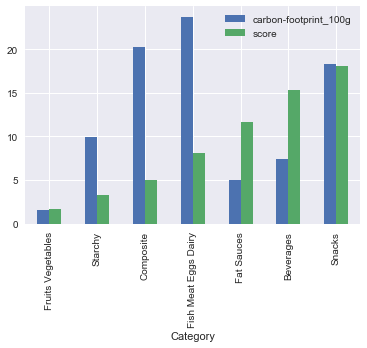

In [33]:
pd.concat((carbon_mean_by_category, score_mean_by_category), axis=1).drop('Unknown').sort_values('score').plot.bar()

In [324]:
countries_en_scores = {}

In [325]:
def random_stuff(row):
    if not np.isnan(row['score']):
        for exportator in row['countries_en'].split(','):
            if exportator in countries_en_scores:
                countries_en_scores[exportator] += [row['score_letter']]
            else:
                countries_en_scores[exportator] = [row['score_letter']]

In [326]:
data[data['countries_en'].notna()].apply(random_stuff, axis=1);

In [328]:
from collections import Counter

In [337]:
a,b, *_ = countries_en_scores.

In [360]:
threshold = 0

In [354]:
{country: Counter(countries_en_scores[country]) for country in countries_en_scores if len(countries_en_scores[country]) > threshold}

{'France': Counter({'E': 247, 'B': 262, 'A': 426, 'C': 427, 'D': 228}),
 'United Kingdom': Counter({'C': 25, 'B': 11, 'D': 5, 'A': 7}),
 'United States': Counter({'A': 1, 'D': 1, 'E': 1}),
 'Germany': Counter({'C': 6, 'D': 7, 'A': 2, 'E': 2}),
 'Netherlands': Counter({'C': 5, 'D': 1, 'E': 1}),
 'Spain': Counter({'C': 5, 'A': 6, 'D': 3, 'B': 1}),
 'Sweden': Counter({'A': 2}),
 'Portugal': Counter({'C': 2}),
 'Belgium': Counter({'E': 4, 'C': 12, 'D': 5, 'B': 6, 'A': 6}),
 'Guadeloupe': Counter({'C': 1, 'E': 1}),
 'Switzerland': Counter({'A': 10, 'B': 4, 'E': 10, 'D': 9, 'C': 14}),
 'Réunion': Counter({'E': 3, 'C': 1, 'D': 1}),
 'India': Counter({'C': 1}),
 'En': Counter({'A': 1}),
 'French Polynesia': Counter({'C': 1}),
 'Luxembourg': Counter({'D': 1}),
 'Italy': Counter({'D': 2, 'E': 3, 'A': 1}),
 'Algeria': Counter({'C': 1}),
 'Dominican Republic': Counter({'C': 1}),
 'Austria': Counter({'C': 1}),
 'Latvia': Counter({'D': 1}),
 'Russia': Counter({'A': 1}),
 'Serbia': Counter({'D': 1}),

In [93]:
{k: pd.Series(exportators_scores[k]).describe() for k in exportators_scores.keys() if len(exportators_scores[k]) > 5}

{'france': count    665.000000
 mean       3.732331
 std        6.751434
 min      -12.000000
 25%       -1.000000
 50%        3.000000
 75%        8.000000
 max       25.000000
 dtype: float64, 'royaume-uni': count    15.00000
 mean      9.40000
 std       7.22891
 min      -2.00000
 25%       3.50000
 50%      11.00000
 75%      14.50000
 max      21.00000
 dtype: float64, 'italie': count    15.000000
 mean      1.266667
 std       5.391351
 min      -5.000000
 25%      -3.000000
 50%       0.000000
 75%       3.500000
 max      12.000000
 dtype: float64, 'espagne': count    16.000000
 mean     -0.187500
 std       5.935416
 min      -9.000000
 25%      -4.000000
 50%      -1.500000
 75%       2.250000
 max      15.000000
 dtype: float64, 'auvergne-rhone-alpes': count     6.000000
 mean     11.333333
 std       2.804758
 min       6.000000
 25%      11.250000
 50%      12.000000
 75%      12.750000
 max      14.000000
 dtype: float64, 'belgique': count    11.000000
 mean      5.72727

In [74]:
data[data['origins_tags'].notna()].apply(random_stuff, axis=1)

254       None
257       None
267       None
272       None
277       None
288       None
300       None
301       None
313       None
353       None
362       None
416       None
518       None
555       None
574       None
575       None
586       None
597       None
605       None
619       None
622       None
629       None
711       None
790       None
799       None
877       None
988       None
1009      None
1041      None
1044      None
          ... 
697862    None
697863    None
697864    None
697866    None
697867    None
697868    None
697869    None
697871    None
697872    None
697874    None
697875    None
697876    None
697877    None
697905    None
697949    None
698014    None
698103    None
698220    None
698241    None
698290    None
698294    None
698312    None
698324    None
698336    None
698380    None
698393    None
698402    None
698405    None
698406    None
698458    None
Length: 42604, dtype: object